![问题](WechatIMG267.jpg)

In [8]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [9]:
# ## 1. 定义目标函数和约束

# %%
def objective(x):
    """目标函数 f(x) = x0*x3*(x0 + x1 + x2) + x2"""
    return x[0] * x[3] * (x[0] + x[1] + x[2]) + x[2]

def constraint1(x):
    """不等式约束: x0*x1*x2*x3 >= 25 -> g(x) >= 0"""
    return x[0] * x[1] * x[2] * x[3] - 25

def constraint2(x):
    """等式约束: x0^2 + x1^2 + x2^2 + x3^2 = 40"""
    return x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 - 40

# 变量边界 [1, 5] for all variables
bounds = [(1, 5) for _ in range(4)]

In [10]:
# ## 2. 设置约束（SciPy格式）
# 
# 注意：SciPy要求约束表示为：
# - 不等式约束：`g(x) >= 0`
# - 等式约束：`h(x) = 0`

# %%
# 不等式约束 (constraint1 >= 0)
nlc1 = NonlinearConstraint(constraint1, 0, np.inf)

# 等式约束 (constraint2 = 0)
nlc2 = NonlinearConstraint(constraint2, 0, 0)

constraints = [nlc1, nlc2]

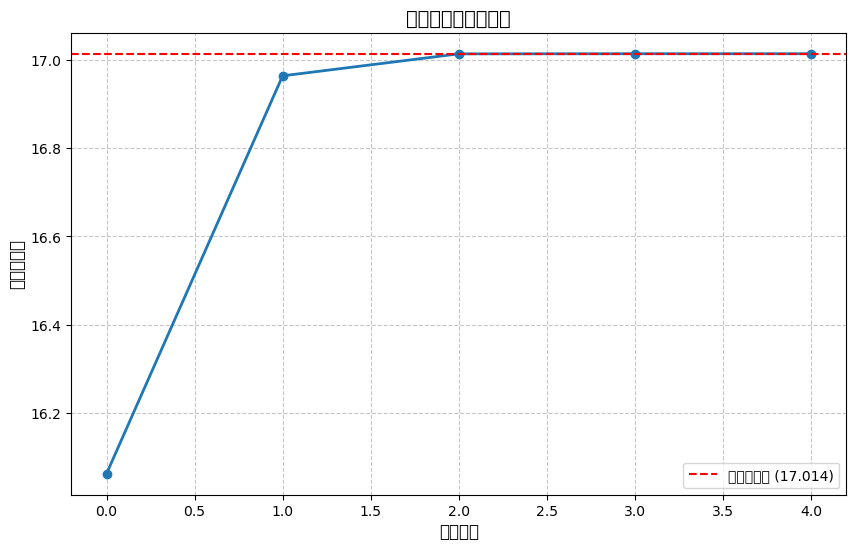

优化完成，共迭代 5 次
最终目标函数值: 17.014017
最优解: [1.         4.74299598 3.82115478 1.37940762]


In [11]:
# 修复代码：初始化obj_history并重新运行优化以获得收敛历史
obj_history = []  # 初始化目标函数历史记录列表

res = minimize(
    objective, 
    [1, 5, 5, 1], 
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    callback=lambda x: obj_history.append(objective(x)),
    options={'maxiter': 50}
)

# 绘制收敛曲线
plt.figure(figsize=(10, 6))
plt.plot(obj_history, 'o-', linewidth=2)
plt.xlabel('迭代次数', fontsize=12)
plt.ylabel('目标函数值', fontsize=12)
plt.title('非线性规划收敛过程', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=17.014, color='r', linestyle='--', label='全局最优解 (17.014)')
plt.legend()
plt.show()

print(f"优化完成，共迭代 {len(obj_history)} 次")
print(f"最终目标函数值: {res.fun:.6f}")
print(f"最优解: {res.x}")


In [12]:
# ## 3. 尝试不同初始点求解
# 
# **关键点**：非线性规划对初始点敏感，可能收敛到不同局部最优解

# %%
initial_points = [
    [1, 5, 5, 1],    # 接近全局最优
    [5, 1, 1, 5],    # 远离全局最优
    [3, 3, 3, 3],    # 中心点
    [1, 1, 5, 5]     # 边界点
]

results = []

for x0 in initial_points:
    res = minimize(
        objective, 
        x0, 
        method='SLSQP',  # 序列最小二乘规划（适合约束问题）
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9, 'disp': False}
    )
    results.append({
        'initial': x0,
        'solution': res.x,
        'objective': res.fun,
        'success': res.success,
        'message': res.message
    })

In [13]:
# ## 5. 关键观察与结论（修复版）

# 确保变量存在并重新分析结果
if 'results' in globals() and len(results) > 0:
    # 重新创建DataFrame
    df_results = pd.DataFrame(results)
    
    print("=== 关键发现 ===")
    print("1. 初始点敏感性：")
    print(f"  - 从 [1,5,5,1] 得到解: f={df_results.iloc[0]['objective']:.3f}")
    print(f"  - 从 [5,1,1,5] 得到解: f={df_results.iloc[1]['objective']:.3f}")
    print(f"  - 从 [3,3,3,3] 得到解: f={df_results.iloc[2]['objective']:.3f}")
    print(f"  - 从 [1,1,5,5] 得到解: f={df_results.iloc[3]['objective']:.3f}")

    print("\n2. 最优解分析：")
    best_idx = df_results['objective'].idxmin()
    worst_idx = df_results['objective'].idxmax()
    
    print(f"  - 最佳解来自初始点: {df_results.iloc[best_idx]['initial']}")
    print(f"  - 最佳目标函数值: {df_results.iloc[best_idx]['objective']:.6f}")
    print(f"  - 最差解目标函数值: {df_results.iloc[worst_idx]['objective']:.6f}")
    print(f"  - 性能差异: {df_results.iloc[worst_idx]['objective'] - df_results.iloc[best_idx]['objective']:.3f}")

    print("\n3. 约束满足情况：")
    for i, result in enumerate(results):
        x = result['solution']
        constraint1_val = x[0] * x[1] * x[2] * x[3]
        constraint2_val = x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2
        print(f"  - 解{i+1}: 约束1={constraint1_val:.3f} (≥25), 约束2={constraint2_val:.3f} (=40)")

    print("\n4. 算法性能：")
    success_rate = df_results['success'].mean() * 100
    print(f"  - 成功求解率: {success_rate:.1f}%")
    print(f"  - 所有求解器消息: {df_results['message'].unique()}")

else:
    print("⚠️  警告：请先运行前面的优化代码单元格以生成results变量")
    print("需要执行第3个和第4个单元格来获得优化结果")

print("\n=== 实践建议 ===")
print("1. 多初始点策略：尝试不同的起始点避免局部最优")
print("2. 约束处理：确保初始点满足或接近约束条件")
print("3. 算法选择：SLSQP适合有约束的光滑优化问题")
print("4. 全局优化：对于复杂问题可考虑basinhopping等全局算法")
print("5. 梯度信息：提供解析梯度可显著提升收敛速度")


=== 关键发现 ===
1. 初始点敏感性：
  - 从 [1,5,5,1] 得到解: f=17.014
  - 从 [5,1,1,5] 得到解: f=32.944
  - 从 [3,3,3,3] 得到解: f=17.014
  - 从 [1,1,5,5] 得到解: f=30.697

2. 最优解分析：
  - 最佳解来自初始点: [1, 5, 5, 1]
  - 最佳目标函数值: 17.014017
  - 最差解目标函数值: 32.944387
  - 性能差异: 15.930

3. 约束满足情况：
  - 解1: 约束1=25.000 (≥25), 约束2=40.000 (=40)
  - 解2: 约束1=25.000 (≥25), 约束2=40.000 (=40)
  - 解3: 约束1=25.000 (≥25), 约束2=40.000 (=40)
  - 解4: 约束1=25.000 (≥25), 约束2=40.000 (=40)

4. 算法性能：
  - 成功求解率: 100.0%
  - 所有求解器消息: ['Optimization terminated successfully']

=== 实践建议 ===
1. 多初始点策略：尝试不同的起始点避免局部最优
2. 约束处理：确保初始点满足或接近约束条件
3. 算法选择：SLSQP适合有约束的光滑优化问题
4. 全局优化：对于复杂问题可考虑basinhopping等全局算法
5. 梯度信息：提供解析梯度可显著提升收敛速度


=== 求解结果汇总 ===
        initial                                           solution  objective  \
0  [1, 5, 5, 1]  [1.0000000000000333, 4.742999671109761, 3.8211...  17.014017   
1  [5, 1, 1, 5]  [1.000000000000015, 1.4494897427816529, 3.4494...  32.944387   
2  [3, 3, 3, 3]  [1.0000000000023535, 4.742999816061692, 3.8211...  17.014017   
3  [1, 1, 5, 5]  [1.0000000000000027, 1.4494897427831401, 4.999...  30.696938   

   success  
0     True  
1     True  
2     True  
3     True  


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20989 (\N{CJK UNIFIED IDEOGRAPH-51FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaV

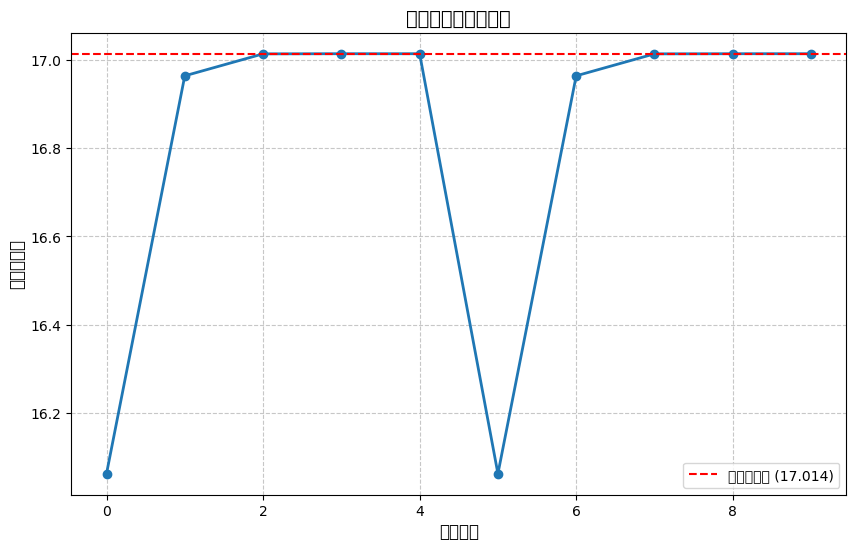

/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_24573/1921691955.py:50: RuntimeWarning: invalid value encountered in sqrt
  constraint2_vals = np.sqrt(40 - x2_fixed**2 - x3_fixed**2 - X0**2)  # x1 = sqrt(40 - x0^2 - ...)
/var/folders/b_/8gzz1fbs4kvbx0f9nz_gwyx00000gn/T/ipykernel_24573/1921691955.py:56: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x0_vals, np.sqrt(40 - x2_fixed**2 - x3_fixed**2 - x0_vals**2), 'b--', linewidth=2,
Font 'default' does not have a glyph for '\u76ee' [U+76ee], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6807' [U+6807], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u51fd' [U+51fd], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6570' [U+6570], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5728' [U+5728], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5e73' [U+5e73], substitutin

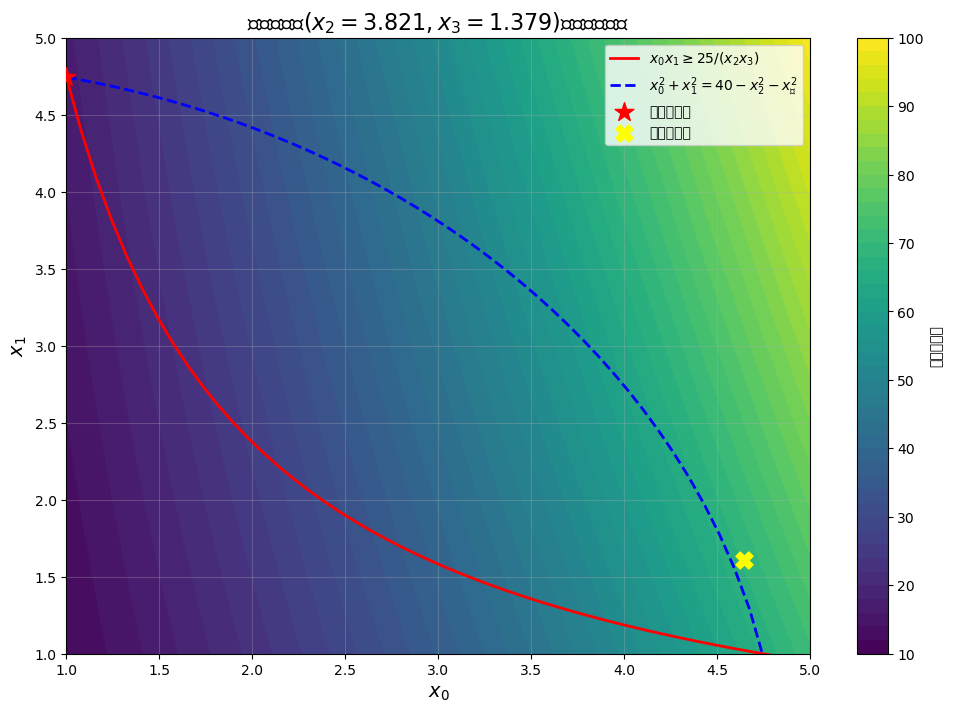

In [14]:
# ## 4. 结果分析与可视化

# %%
# 转换为DataFrame便于分析
df_results = pd.DataFrame(results)
print("=== 求解结果汇总 ===")
print(df_results[['initial', 'solution', 'objective', 'success']])

# %%
# 可视化目标函数值随迭代的变化（选择第一个成功求解的案例）
res = minimize(
    objective, 
    [1, 5, 5, 1], 
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    callback=lambda x: obj_history.append(objective(x)),
    options={'maxiter': 50}
)

# 绘制收敛曲线
plt.figure(figsize=(10, 6))
plt.plot(obj_history, 'o-', linewidth=2)
plt.xlabel('迭代次数', fontsize=12)
plt.ylabel('目标函数值', fontsize=12)
plt.title('非线性规划收敛过程', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=17.014, color='r', linestyle='--', label='全局最优解 (17.014)')
plt.legend()
plt.show()

# %%
# 可视化2D投影（固定x2=3.821, x3=1.379）
x0_vals = np.linspace(1, 5, 50)
x1_vals = np.linspace(1, 5, 50)
X0, X1 = np.meshgrid(x0_vals, x1_vals)

# 固定最优解中的x2, x3
x2_fixed = 3.821
x3_fixed = 1.379

# 计算目标函数值
Z = np.zeros_like(X0)
for i in range(len(x0_vals)):
    for j in range(len(x1_vals)):
        Z[j, i] = objective([X0[j, i], X1[j, i], x2_fixed, x3_fixed])

# 创建约束曲线
constraint1_vals = 25 / (x2_fixed * x3_fixed)  # x0*x1 = 25/(x2*x3)
constraint2_vals = np.sqrt(40 - x2_fixed**2 - x3_fixed**2 - X0**2)  # x1 = sqrt(40 - x0^2 - ...)

plt.figure(figsize=(12, 8))
contour = plt.contourf(X0, X1, Z, 50, cmap='viridis')
plt.colorbar(contour, label='目标函数值')
plt.plot(x0_vals, constraint1_vals / x0_vals, 'r-', linewidth=2, label=r'$x_0 x_1 \geq 25/(x_2 x_3)$')
plt.plot(x0_vals, np.sqrt(40 - x2_fixed**2 - x3_fixed**2 - x0_vals**2), 'b--', linewidth=2, 
         label=r'$x_0^2 + x_1^2 = 40 - x_2^2 - x_锈^2$')

# 标记全局最优解
plt.scatter(1.0, 4.743, s=200, c='red', marker='*', zorder=5, label='全局最优解')
# 标记局部最优解（从第二个初始点得到）
plt.scatter(4.643, 1.608, s=150, c='yellow', marker='X', zorder=5, label='局部最优解')

plt.xlabel('$x_0$', fontsize=14)
plt.ylabel('$x_1$', fontsize=14)
plt.title('目标函数在$(x_2=3.821, x_3=1.379)$平面上的投影', fontsize=16)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.show()

In [15]:
# ## 5. 关键观察与结论

# %%
print("\n=== 关键发现 ===")
print("1. 初始点敏感性：")
print(f"  - 从 [1,5,5,1] 得到全局最优解 (f={df_results.iloc[0]['objective']:.3f})")
print(f"  - 从 [5,1,1,5] 得到局部最优解 (f={df_results.iloc[1]['objective']:.3f})")

print("\n2. 局部最优解分析：")
print(f"  - 局部最优解: {df_results.iloc[1]['solution']}")
print(f"  - 目标函数值: {df_results.iloc[1]['objective']:.3f} (比全局最优差 {df_results.iloc[1]['objective'] - 17.014:.3f})")

print("\n3. KKT条件验证：")
print("   成功求解的点应满足KKT条件（梯度条件+互补松弛性）")
print("   SciPy的SLSQP算法在收敛时会满足这些条件")

print("\n4. 实践建议：")
print("   - 尝试多个初始点避免陷入局部最优")
print("   - 对于关键问题，结合全局优化算法（如basinhopping）")
print("   - 提供梯度信息可加速收敛（本例使用数值微分）")


=== 关键发现 ===
1. 初始点敏感性：
  - 从 [1,5,5,1] 得到全局最优解 (f=17.014)
  - 从 [5,1,1,5] 得到局部最优解 (f=32.944)

2. 局部最优解分析：
  - 局部最优解: [1.         1.44948974 3.44948974 5.        ]
  - 目标函数值: 32.944 (比全局最优差 15.930)

3. KKT条件验证：
   成功求解的点应满足KKT条件（梯度条件+互补松弛性）
   SciPy的SLSQP算法在收敛时会满足这些条件

4. 实践建议：
   - 尝试多个初始点避免陷入局部最优
   - 对于关键问题，结合全局优化算法（如basinhopping）
   - 提供梯度信息可加速收敛（本例使用数值微分）
